In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import psycopg2
import pandas as pd 

### Storing Data in PostGreSQl

In [2]:
conn = psycopg2.connect(
    dbname="tpc_ds", user="postgres", password="password", host="localhost", port="5432"
)
cur = conn.cursor()

query = "SELECT * FROM store_sales LIMIT 100;"  
df = pd.read_sql(query, conn)

print(df.head())

cur.close()
conn.close()


   ss_sold_date_sk  ss_sold_time_sk  ss_item_sk  ss_customer_sk  ss_cdemo_sk  \
0        2451813.0          65495.0        3617         67006.0     591617.0   
1        2451813.0          65495.0       13283         67006.0     591617.0   
2        2451813.0          65495.0       13631         67006.0     591617.0   
3        2451813.0          65495.0        5981         67006.0     591617.0   
4        2451813.0          65495.0        4553         67006.0     591617.0   

   ss_hdemo_sk  ss_addr_sk  ss_store_sk  ss_promo_sk  ss_ticket_number  ...  \
0       3428.0     24839.0         10.0        161.0                 1  ...   
1       3428.0     24839.0         10.0        154.0                 1  ...   
2       3428.0     24839.0         10.0        172.0                 1  ...   
3       3428.0     24839.0         10.0        280.0                 1  ...   
4       3428.0     24839.0         10.0        236.0                 1  ...   

   ss_sales_price  ss_ext_discount_amt  ss_e

C:\Users\dell\AppData\Local\Temp\ipykernel_19568\1016413625.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


### Schema Matching with BERT using Cosine Similarity 

In [3]:
current_schema = [
    'ss_sold_date_sk', 'ss_sold_time_sk', 'ss_item_sk', 'ss_customer_sk', 'ss_cdemo_sk',
    'ss_hdemo_sk', 'ss_addr_sk', 'ss_store_sk', 'ss_promo_sk', 'ss_ticket_number', 'ss_quantity',
    'ss_wholesale_cost', 'ss_list_price', 'ss_sales_price', 'ss_ext_discount_amt', 'ss_ext_sales_price',
    'ss_ext_wholesale_cost', 'ss_ext_list_price', 'ss_ext_tax', 'ss_coupon_amt', 'ss_net_paid',
    'ss_net_paid_inc_tax', 'ss_net_profit'
]

simulated_schema = [
    'sold_date', 'sold_time', 'item_id', 'customer_id', 'customer_demo_id', 'household_demo_id',
    'address_id', 'store_id', 'promo_id', 'ticket_number', 'quantity_sold', 'wholesale_cost',
    'list_price', 'sales_price', 'discount_amount', 'total_sales', 'wholesale_total', 'list_price_total',
    'total_tax', 'coupon_amount', 'net_paid', 'net_paid_with_tax', 'net_profit'
]

from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def encode_columns(columns):
    inputs = tokenizer(columns, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  

# Encode both schemas
current_schema_embeddings = encode_columns(current_schema)
simulated_schema_embeddings = encode_columns(simulated_schema)

# Compute cosine similarity on the embeddings
cosine_sim = torch.nn.functional.cosine_similarity(current_schema_embeddings, simulated_schema_embeddings)

print(cosine_sim)


c:\Users\dell\Desktop\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([0.8836, 0.8838, 0.8711, 0.8495, 0.7860, 0.8144, 0.7991, 0.8632, 0.8617,
        0.9102, 0.8277, 0.9480, 0.9385, 0.9437, 0.7837, 0.7847, 0.7836, 0.8940,
        0.8889, 0.8721, 0.9511, 0.9206, 0.9259])


### Query Optimization using BERT

In [4]:
import time
import psycopg2
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# encode columns using BERT
def encode_columns(columns):
    inputs = tokenizer(columns, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Query optimization 
def optimize_query_with_bert(natural_language_query, schema_embeddings, current_schema):
    query_embedding = encode_columns([natural_language_query])  # embedding of the query
    similarities = torch.nn.functional.cosine_similarity(query_embedding, schema_embeddings)  # Match with schema
    best_match_index = similarities.argmax()
    
    optimized_column = current_schema[best_match_index.item()]  # Get the actual column name based on similarity 
    optimized_query = f"SELECT {optimized_column} FROM store_sales WHERE ss_sales_price > 100"
    return optimized_query

# measure execution time for queries
def measure_execution_time(query):
    conn = psycopg2.connect(
        dbname="tpc_ds", user="postgres", password="password", host="localhost", port="5432"
    )
    start_time = time.time()
    with conn.cursor() as cur:
        cur.execute(query)
    execution_time = time.time() - start_time
    conn.close()
    return execution_time

# Run the query without optimization
query = "SELECT * FROM store_sales WHERE ss_sales_price > 100"
time_before = measure_execution_time(query)

# Now optimize the query with BERT and run it
schema_embeddings = encode_columns(current_schema)  # Embedding for schema
optimized_query = optimize_query_with_bert("Get all sales with price > 100", schema_embeddings, current_schema)
time_after = measure_execution_time(optimized_query)

# Print the execution times
print(f"Execution Time - Before Optimization: {time_before:.2f}s")
print(f"Execution Time - After Optimization: {time_after:.2f}s")


Execution Time - Before Optimization: 6.02s
Execution Time - After Optimization: 1.37s


### Defined Threshold to ensure correct mapping of differnt Schema's 

In [5]:
threshold = 0.7 
matches = {}

for i, sim_score in enumerate(cosine_sim):
    if sim_score >= threshold:
        matches[current_schema[i]] = simulated_schema[i]

print("Schema Matches:", matches)


Schema Matches: {'ss_sold_date_sk': 'sold_date', 'ss_sold_time_sk': 'sold_time', 'ss_item_sk': 'item_id', 'ss_customer_sk': 'customer_id', 'ss_cdemo_sk': 'customer_demo_id', 'ss_hdemo_sk': 'household_demo_id', 'ss_addr_sk': 'address_id', 'ss_store_sk': 'store_id', 'ss_promo_sk': 'promo_id', 'ss_ticket_number': 'ticket_number', 'ss_quantity': 'quantity_sold', 'ss_wholesale_cost': 'wholesale_cost', 'ss_list_price': 'list_price', 'ss_sales_price': 'sales_price', 'ss_ext_discount_amt': 'discount_amount', 'ss_ext_sales_price': 'total_sales', 'ss_ext_wholesale_cost': 'wholesale_total', 'ss_ext_list_price': 'list_price_total', 'ss_ext_tax': 'total_tax', 'ss_coupon_amt': 'coupon_amount', 'ss_net_paid': 'net_paid', 'ss_net_paid_inc_tax': 'net_paid_with_tax', 'ss_net_profit': 'net_profit'}


###  Clustering to group similar schemas

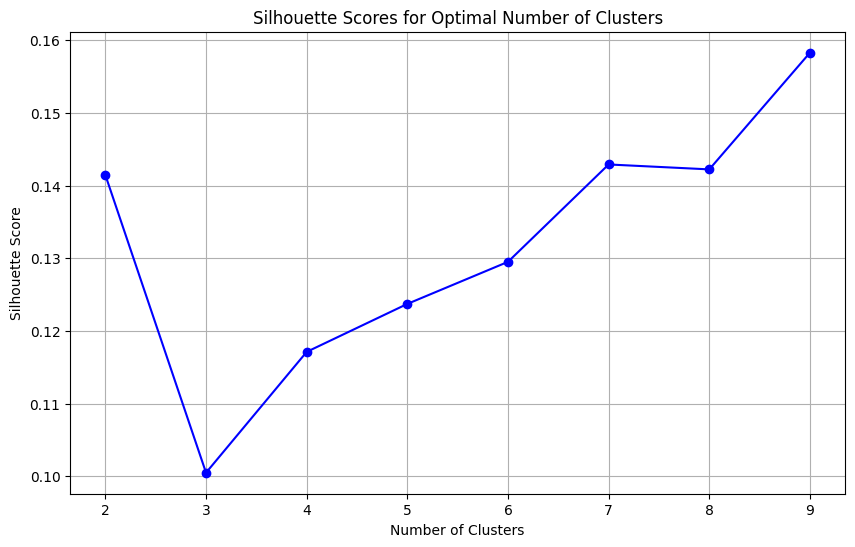

Optimal number of clusters based on Silhouette Score: 9
Cluster 0: ['item_id', 'customer_id', 'customer_demo_id', 'household_demo_id', 'address_id', 'store_id', 'promo_id']
Cluster 1: ['ss_ext_discount_amt', 'ss_ext_sales_price', 'ss_ext_wholesale_cost', 'ss_ext_list_price', 'ss_coupon_amt']
Cluster 2: ['ss_wholesale_cost', 'ss_list_price', 'ss_sales_price', 'sold_date', 'sold_time', 'quantity_sold', 'wholesale_cost', 'list_price', 'sales_price', 'discount_amount', 'total_sales', 'wholesale_total', 'list_price_total', 'coupon_amount']
Cluster 3: ['ss_sold_date_sk', 'ss_sold_time_sk', 'ss_item_sk', 'ss_customer_sk', 'ss_cdemo_sk', 'ss_hdemo_sk', 'ss_addr_sk', 'ss_store_sk', 'ss_promo_sk']
Cluster 4: ['ss_ext_tax', 'total_tax']
Cluster 5: ['ss_ticket_number', 'ticket_number']
Cluster 6: ['ss_net_paid_inc_tax', 'net_paid_with_tax']
Cluster 7: ['ss_quantity']
Cluster 8: ['ss_net_paid', 'ss_net_profit', 'net_paid', 'net_profit']


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

combined_embeddings = torch.cat((current_schema_embeddings, simulated_schema_embeddings), dim=0).numpy()

silhouette_scores = []
range_n_clusters = range(2, 10)  

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='euclidean')
    cluster_labels = clustering.fit_predict(combined_embeddings)  # Use the raw embeddings directly
    silhouette_avg = silhouette_score(combined_embeddings, cluster_labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_clusters}")

final_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='average', metric='euclidean')
final_labels = final_clustering.fit_predict(combined_embeddings)

for cluster_id in np.unique(final_labels):
    cluster_columns = [current_schema[i] if i < len(current_schema) else simulated_schema[i - len(current_schema)] 
                       for i in range(len(final_labels)) if final_labels[i] == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_columns}")


### Dynamic Model Updates if schema changes

In [7]:
def track_schema_changes():
    conn = psycopg2.connect(
        dbname="tpc_ds", user="postgres", password="password", host="localhost", port="5432"
    )
    query = """
        SELECT column_name FROM information_schema.columns
        WHERE table_name = 'store_sales';
    """
    with conn.cursor() as cur:
        cur.execute(query)
        updated_columns = [row[0] for row in cur.fetchall()]
    conn.close()
    return updated_columns

# Update embeddings when schema changes
def update_embeddings_if_needed():
    updated_schema = track_schema_changes()
    if set(updated_schema) != set(current_schema):
        print("Schema updated, recalculating embeddings...")
        updated_embeddings = encode_columns(updated_schema)
        return updated_embeddings
    else:
        print("No schema changes detected.")
        return current_schema_embeddings

updated_embeddings = update_embeddings_if_needed()


No schema changes detected.


In [8]:
def encode_schema(schema):
    inputs = tokenizer(schema, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

schema_embeddings = encode_schema(current_schema)  


### Function to Translate textual query to SQL

In [9]:
def translate_query_to_sql(natural_language_query):
    query_embedding = encode_schema([natural_language_query])  
    similarities = torch.nn.functional.cosine_similarity(query_embedding, schema_embeddings)
    matched_column_index = similarities.argmax()
    
    column_name = current_schema[matched_column_index]
    sql_query = f"SELECT {column_name} FROM store_sales WHERE {column_name} > 100"
    return sql_query


In [10]:
# Execute the generated SQL query
def execute_sql_query(sql_query):
    conn = psycopg2.connect(
        dbname="tpc_ds", user="postgres", password="password", host="localhost", port="5432"
    )
    with conn.cursor() as cursor:
        cursor.execute(sql_query)
        results = cursor.fetchall()
    conn.close()
    return results


In [11]:
import time

def measure_execution_time(sql_query):
    start_time = time.time()
    results = execute_sql_query(sql_query)
    execution_time = time.time() - start_time
    return execution_time, results


### Generate SQL query from text

In [ ]:
natural_language_query = "Get all sales with price > 100"

sql_query = translate_query_to_sql(natural_language_query)
print("Generated SQL Query:", sql_query)

# execution_time, results = measure_execution_time(sql_query)
# print(f"Execution Time: {execution_time:.2f} seconds")
# print("Query Results:", results)


Generated SQL Query: SELECT ss_ext_sales_price FROM store_sales WHERE ss_ext_sales_price > 100
